<a href="https://colab.research.google.com/github/akash-agni/DeepLearning/blob/main/Santender_Bank_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Deep Learning to Solve Kaggles Santander Customer Transaction Prediction Challenge.

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle competitions download -c santander-customer-transaction-prediction

 98% 122M/125M [00:00<00:00, 114MB/s]  
100% 125M/125M [00:00<00:00, 160MB/s]
  0% 0.00/462k [00:00<?, ?B/s]
100% 462k/462k [00:00<00:00, 151MB/s]
 97% 121M/125M [00:01<00:00, 67.1MB/s]
100% 125M/125M [00:01<00:00, 95.7MB/s]


In [3]:
! unzip train.csv.zip
! unzip test.csv.zip
! unzip sample_submission.csv.zip
! rm -rf train.csv.zip test.csv.zip sample_submission.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
! pip install -U imbalanced-learn
import imblearn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.7.0)


In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [3]:
df = pd.read_csv('train.csv')
print(f'Shape of Training Data is : {df.shape[0]} rows and {df.shape[1]} columns')
df.sample(3)

Shape of Training Data is : 200000 rows and 202 columns


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
194279,train_194279,0,12.7336,5.6785,9.6444,3.5443,10.8726,6.9868,6.0555,14.6237,3.2273,5.9184,10.1450,-0.0837,14.1803,14.7844,11.4037,14.1362,10.6927,-10.6313,4.4807,3.6263,5.2659,9.9420,2.5551,2.5048,6.7803,13.4929,-0.1684,0.8832,4.9559,7.2574,-11.8735,12.1107,-3.1692,15.6149,11.0021,0.3123,0.2918,5.5476,...,26.0601,5.7663,7.1263,8.6879,-7.3538,23.5701,2.7024,6.7945,2.7222,5.7090,7.4265,-5.8159,28.5636,-9.0880,28.6919,6.3112,8.1081,14.1107,-11.1171,0.7194,-5.8565,9.2718,7.2341,17.3453,8.4219,-4.1069,6.9273,-0.8759,14.7900,0.5588,6.1775,6.4155,3.2426,3.5834,16.4015,1.1838,7.0001,8.4827,12.3842,-13.2745
195958,train_195958,0,8.8256,-4.9503,12.1827,6.1415,11.8065,-2.4392,4.5887,17.6741,2.4698,6.4447,3.9478,4.0030,13.9825,8.6444,3.9380,13.9095,7.7957,-3.3685,4.5432,13.6711,9.7612,11.4495,2.2376,3.8459,8.8261,14.1251,-12.4376,-2.1760,5.9241,9.3865,-5.4714,10.8203,-0.4009,11.1917,10.9670,8.8961,3.1259,4.0398,...,24.3294,5.4203,4.4665,10.1938,-4.7221,17.1971,3.6062,-11.3350,1.8893,5.7102,-2.7801,4.5127,16.0758,-8.6435,17.2618,14.1105,4.2752,7.8918,0.5448,3.1175,-1.7723,10.0144,0.3148,6.2392,25.5099,-3.3951,4.8750,0.2329,19.3623,1.6037,-6.0863,4.9344,1.9741,8.2986,19.8533,-0.5018,0.8405,9.3046,14.3395,-3.3651
9916,train_9916,0,12.4300,-5.0272,5.6638,6.6510,11.3930,-15.7812,4.9319,12.2096,3.2162,8.9487,0.3413,-6.6214,13.7430,6.6019,7.6777,14.0603,10.0035,-3.4440,24.0936,12.5805,6.2361,16.9948,5.2171,3.0820,17.4561,14.1902,-15.7814,-0.6541,4.5570,6.9367,-25.2546,11.4057,-3.1365,10.3710,12.0047,5.2172,1.0738,2.8327,...,14.9348,5.5112,6.8321,3.9664,-11.5367,19.7466,3.3245,3.9413,1.7319,4.9115,0.2505,-9.4744,23.6352,0.2748,23.6441,9.3181,-3.4475,11.1337,6.5552,3.4878,2.8956,9.6085,-2.4940,9.7524,27.6334,-0.0004,5.7314,-30.9970,12.8739,2.2234,5.3051,3.5276,0.3237,6.3881,22.6581,-0.3000,4.1368,8.1411,17.5105,17.6953


In [4]:
mean = list()
std = list()
skewness = list()
kurt = list()
for var in df.drop(['ID_code', 'target'], axis=1).columns:
  mean.append(np.mean(df[var]))
  std.append(np.std(df[var]))
  skewness.append(skew(df[var]))
  kurt.append(kurtosis(df[var]))

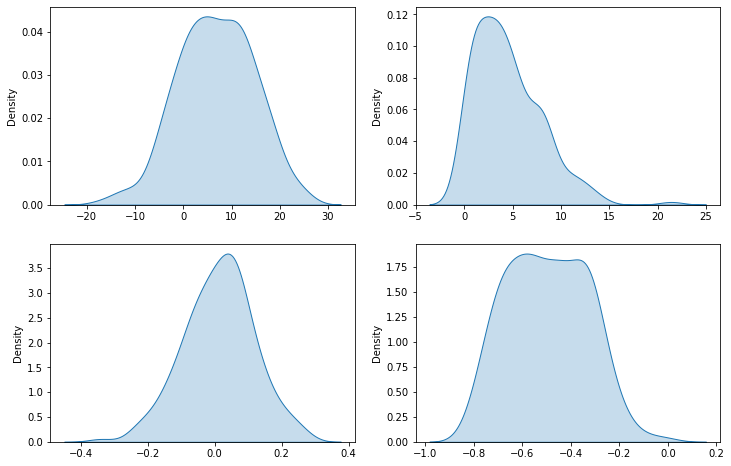

In [5]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
fig = sns.kdeplot(mean, ax=ax[0][0], shade=True, label="Distribution of Mean")
fig = sns.kdeplot(std, ax=ax[0][1], shade=True, label="Distribution of Standard Variance")
fig = sns.kdeplot(skewness, ax=ax[1][0],shade=True, label="Distribution of Skewness")
fig = sns.kdeplot(kurt, ax=ax[1][1],shade=True, label="Distribution of Kurtosis")

In [6]:
df['mean'] = np.mean(df.drop(['ID_code','target'], axis=1), axis=1)
df['median'] = np.median(df.drop(['ID_code','target'], axis=1), axis=1)
df['max'] = np.max(df.drop(['ID_code','target'], axis=1), axis=1)
df['min'] = np.min(df.drop(['ID_code','target'], axis=1), axis=1)
df['std'] = np.std(df.drop(['ID_code','target'], axis=1), axis=1)
df['skewness'] = skew(df.drop(['ID_code','target'], axis=1), axis=1)
df['kurtosis'] = kurtosis(df.drop(['ID_code','target'], axis=1), axis=1)

In [7]:
df.iloc[:,202:].head()

,mean,median,max,min,std,skewness,kurtosis
0,7.281591,6.7806,43.1127,-21.4494,9.761325,0.190000,1.736974
1,7.076818,7.1051,40.5632,-47.3797,11.146304,-0.688164,5.202860
2,6.204483,5.9525,33.8820,-22.4038,9.083563,-0.066380,0.853246
3,6.441159,6.5850,38.1015,-35.1659,10.158122,-0.570874,3.127617
4,6.771155,6.9087,41.1037,-65.4863,12.474544,-1.860747,10.866152


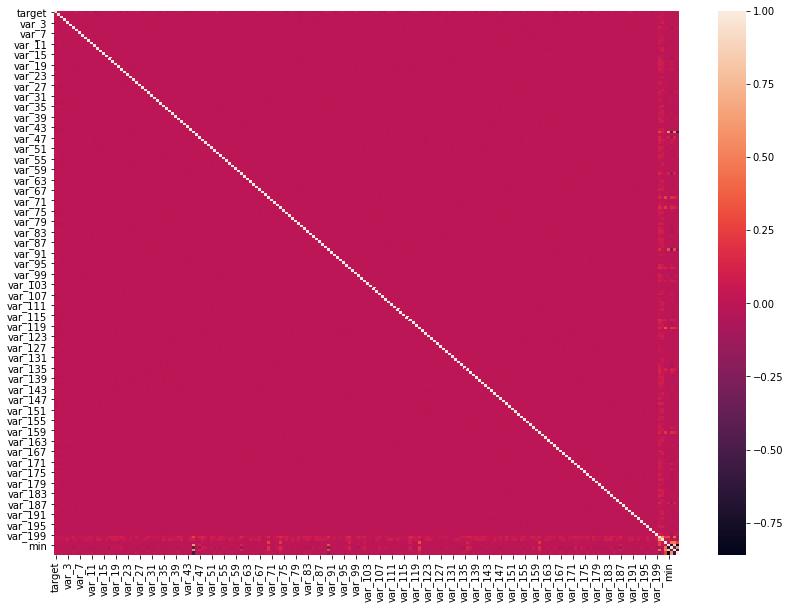

In [8]:
corr_mat = df.drop(['ID_code'], axis=1).corr()
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(corr_mat)

In [9]:
corr_mat['target'].sort_values(ascending=False).head(10)

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
var_22     0.060558
var_99     0.058367
var_190    0.055973
var_2      0.055870
var_133    0.054548
Name: target, dtype: float64

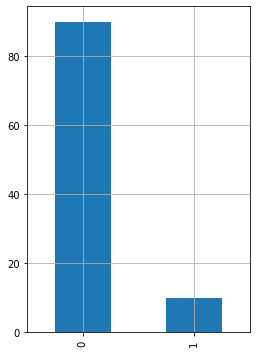

In [10]:
fig, ax = plt.subplots(figsize=(4,6))
(df['target'].value_counts()/len(df)*100).plot.bar(ax)
plt.grid()

In [11]:
df_train, df_test = train_test_split(df.drop('ID_code', axis=1))
df_val, df_test = train_test_split(df_test, test_size=0.4)
print(f"Shape of Training Data : {df_train.shape[0]} rows")
print(f"Shape of Validation Data : {df_val.shape[0]} rows")
print(f"Shape of Testing Data : {df_test.shape[0]} rows")

Shape of Training Data : 150000 rows
Shape of Validation Data : 30000 rows
Shape of Testing Data : 20000 rows


In [12]:
X_train, X_val, X_test= df_train.drop('target', axis=1), df_val.drop('target', axis=1), df_test.drop('target', axis=1)
y_train, y_val, y_test = df_train['target'], df_val['target'], df_test['target']

In [13]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy=0.3)
#under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.7)

X_train, y_train = smote.fit_resample(X_train, y_train)
#X_train, y_train = under.fit_resample(X_train, y_train)

In [14]:
s_scaler = StandardScaler()
s_scaler.fit(X_train)
X_train = s_scaler.transform(X_train)
X_val = s_scaler.transform(X_val)
X_test = s_scaler.transform(X_test)

In [57]:
inputs = tf.keras.Input(X_train.shape[1])
x = tf.keras.layers.Dense(207, activation='relu', kernel_regularizer='l2')(inputs)
x = tf.keras.layers.BatchNormalization()(x)

for _ in range(1):
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(4, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [58]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 207)]             0         
_________________________________________________________________
dense_44 (Dense)             (None, 207)               43056     
_________________________________________________________________
batch_normalization_16 (Batc (None, 207)               828       
_________________________________________________________________
dense_45 (Dense)             (None, 64)                13312     
_________________________________________________________________
batch_normalization_17 (Batc (None, 64)                256       
_________________________________________________________________
dense_46 (Dense)             (None, 16)                1040      
_________________________________________________________________
batch_normalization_18 (Batc (None, 16)                64  

In [53]:
import os, datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-Itre1"))
call_back = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [60]:
history = model.fit(x=X_train, y=y_train, verbose=1,epochs=100, validation_data=(X_val, y_val), batch_size=32
                    , callbacks=call_back)

Epoch 1/100
5484/5484 [==============================] - 38s 7ms/step - loss: 0.4863 - auc: 0.8744 - val_loss: 0.4377 - val_auc: 0.8050
Epoch 2/100
5484/5484 [==============================] - 38s 7ms/step - loss: 0.4875 - auc: 0.8796 - val_loss: 0.4350 - val_auc: 0.8129
Epoch 3/100
5484/5484 [==============================] - 38s 7ms/step - loss: 0.4847 - auc: 0.8810 - val_loss: 0.4314 - val_auc: 0.8062
Epoch 4/100
5484/5484 [==============================] - 38s 7ms/step - loss: 0.4782 - auc: 0.8820 - val_loss: 0.4329 - val_auc: 0.8158
Epoch 5/100
5484/5484 [==============================] - 38s 7ms/step - loss: 0.4743 - auc: 0.8823 - val_loss: 0.4138 - val_auc: 0.8047
Epoch 6/100
5484/5484 [==============================] - 38s 7ms/step - loss: 0.4734 - auc: 0.8833 - val_loss: 0.4270 - val_auc: 0.8074
Epoch 7/100
5484/5484 [==============================] - 38s 7ms/step - loss: 0.4735 - auc: 0.8833 - val_loss: 0.4298 - val_auc: 0.8049
Epoch 8/100
5484/5484 [=========================

KeyboardInterrupt: ignored

In [61]:
model.evaluate(X_test, y_test)

625/625 [==============================] - 2s 3ms/step - loss: 0.4364 - auc: 0.8370


[0.4363518953323364, 0.8370416164398193]

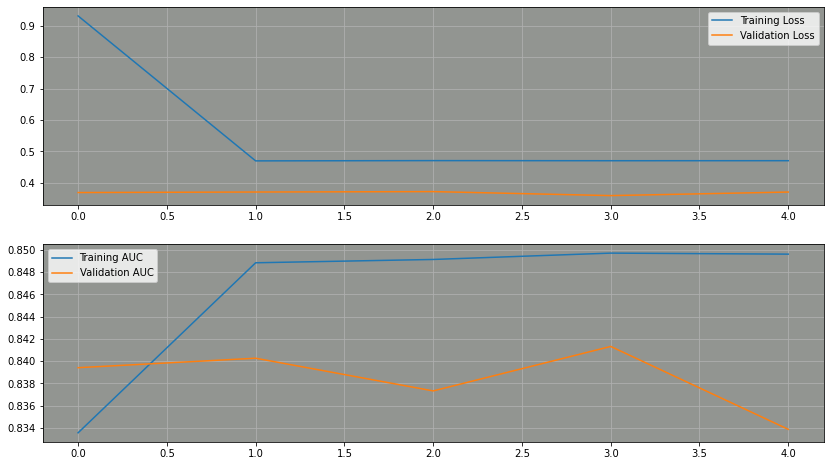

In [62]:
fig, ax = plt.subplots(nrows = 2, figsize = (14,8))
x_rng = list(range(len(history.history['loss'])))
sns.lineplot(x=x_rng, y=history.history['loss'], ax=ax[0], label='Training Loss')
sns.lineplot(x=x_rng, y=history.history['val_loss'], ax=ax[0], label='Validation Loss')
ax[0].set_facecolor('xkcd:grey')
ax[0].grid()
sns.lineplot(x=x_rng, y=history.history['auc'], ax=ax[1], label='Training AUC')
fig = sns.lineplot(x=x_rng, y=history.history['val_auc'], ax=ax[1], label='Validation AUC')
ax[1].set_facecolor('xkcd:grey')
ax[1].grid()

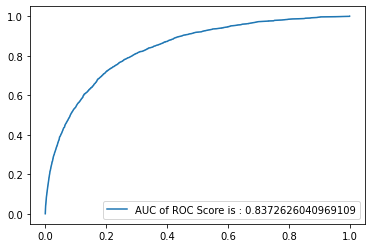

In [82]:
y_pred = model.predict(X_test)
roc_score = metrics.roc_auc_score(y_test, y_pred)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(x=fpr, y=tpr, label=f"AUC of ROC Score is : {roc_score}")

In [86]:
gmeans = np.sqrt(tpr*(1-fpr))
thres = threshold[np.argmax(gmeans)]
print(f"Threshold to Use : {thres}")

Threshold to Use : 0.17544621229171753


In [68]:
df_sub = pd.read_csv('test.csv')
df_sub['mean'] = np.mean(df_sub.drop(['ID_code'], axis=1), axis=1)
df_sub['median'] = np.median(df_sub.drop(['ID_code'], axis=1), axis=1)
df_sub['max'] = np.max(df_sub.drop(['ID_code'], axis=1), axis=1)
df_sub['min'] = np.min(df_sub.drop(['ID_code'], axis=1), axis=1)
df_sub['std'] = np.std(df_sub.drop(['ID_code'], axis=1), axis=1)
df_sub['skewness'] = skew(df_sub.drop(['ID_code'], axis=1), axis=1)
df_sub['kurtosis'] = kurtosis(df_sub.drop(['ID_code'], axis=1), axis=1)
X_sub = df_sub.drop(['ID_code'], axis=1)
X_sub = s_scaler.transform(X_sub)

In [100]:
y_sub = pd.DataFrame(df_sub['ID_code'].copy())
y_sub['target'] = model.predict(X_sub)
y_sub['target'] = (y_sub['target'] >= thres)*1
y_sub.head()

,ID_code,target
0,test_0,1
1,test_1,1
2,test_2,0
3,test_3,1
4,test_4,1


In [102]:
y_sub.to_csv('Submission.csv', index=False)

In [104]:
! kaggle competitions submit -c santander-customer-transaction-prediction -f Submission.csv -m "First Attempt"

100% 2.56M/2.56M [00:00<00:00, 5.22MB/s]
Successfully submitted to Santander Customer Transaction Prediction